for this notebook we assume that all samples have successfully been processed with spacemake

if not, please do so first

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

import os
from utils import downsampling, digital_expression, get_genic_reads_and_umis
from concurrent.futures import ThreadPoolExecutor

%load_ext autoreload
%autoreload 2

RANDOM_SEED = 666

In [2]:
fov_area_um2 = 1000000
pseudo_cell_size = 127.3
slide_seq_bead_size = 78.5
visium_spot_size = 2376
dbit_seq_spot_size = 625

n_pseudo_cells = int(fov_area_um2 / pseudo_cell_size)
n_spots_slide_seq = int(fov_area_um2 / slide_seq_bead_size)
n_visium_spots = int(fov_area_um2 / visium_spot_size)
n_spots_dbit_seq = int(fov_area_um2 / dbit_seq_spot_size)

In [14]:
spacemake_dir_path = '../../spacemake/'

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump({}, f, protocol=pkl.HIGHEST_PROTOCOL)

## open-ST

### e13 mouse brain rep1

In [4]:
open_st_mb = sc.read(f'{spacemake_dir_path}projects/open_st/processed_data/e13_mouse_rep1/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].
Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].


In [5]:
# remove background
cutoff = 700
open_st_mb_cutoff = open_st_mb[open_st_mb.obs.total_counts > cutoff].copy()
plt.hist(open_st_mb.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 2000])
plt.show()
sc.pl.spatial(open_st_mb_cutoff, color='total_counts', spot_size=300)

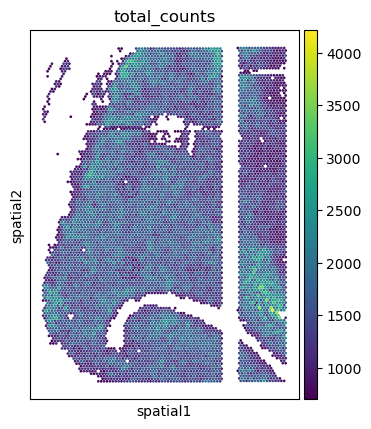

In [6]:
# select field of view
open_st_mb_left_border = 148000
open_st_mb_right_border = 175000
open_st_mb_top_border = 615000
open_st_mb_bottom_border = 652000
sc.pl.spatial(open_st_mb_cutoff[(open_st_mb_cutoff.obsm['spatial'][:, 0] > open_st_mb_left_border) &
                                (open_st_mb_cutoff.obsm['spatial'][:, 0] < open_st_mb_right_border) &
                                (open_st_mb_cutoff.obsm['spatial'][:, 1] > open_st_mb_top_border) &
                                (open_st_mb_cutoff.obsm['spatial'][:, 1] < open_st_mb_bottom_border)],
              color='total_counts',
              spot_size=300)

AnnData object with n_obs × n_vars = 8592 × 37552
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'fc_009_L3b_tile_2416', 'fc_009_L3b_tile_2417', 'fc_009_L3b_tile_2418', 'fc_009_L3b_tile_2419', 'fc_009_L3b_tile_2516', 'fc_009_L3b_tile_2517', 'fc_009_L3b_tile_2518', 'fc_009_L3b_tile_2519', 'fc_009_L3b_tile_2616', 'fc_009_L3b_tile_2617', 'fc_009_L3b_tile_2618', 'fc_009_L3b_tile_2619'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 37552
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'fc_009_L3b_tile_2416', 'fc_009_L3b_tile_2417', 'fc_009_L3b_tile_2418', 'fc_009_L3b_tile_2419

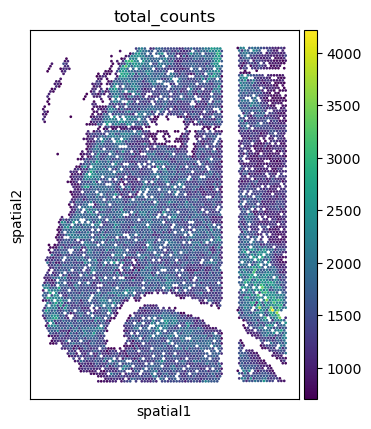

In [7]:
# sample pseudo cells from fov
open_st_mb_fov = open_st_mb_cutoff[(open_st_mb_cutoff.obs.x_pos > open_st_mb_left_border) &
                                   (open_st_mb_cutoff.obs.x_pos < open_st_mb_right_border) &
                                   (open_st_mb_cutoff.obs.y_pos > open_st_mb_top_border) &
                                   (open_st_mb_cutoff.obs.y_pos < open_st_mb_bottom_border)].copy()
print(open_st_mb_fov)

rng = np.random.default_rng(RANDOM_SEED)
open_st_mb_fov_subset = open_st_mb_fov[rng.choice(open_st_mb_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(open_st_mb_fov_subset)

sc.pl.spatial(open_st_mb_fov_subset, color='total_counts', spot_size=300)

In [11]:
# get barcodes from pseudo cells
open_st_mb_fov_subset_bcs = []
for pc_index in open_st_mb_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = open_st_mb_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    open_st_mb_fov_subset_bcs.extend(open_st_mb_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(open_st_mb_fov_subset_bcs)

1719750

In [13]:
# save barcodes to file
os.makedirs(os.path.dirname('open_st/mouse/e13_rep1/'), exist_ok=True)
with open('open_st/mouse/e13_rep1/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(open_st_mb_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:open_st/mouse/e13_rep1/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/open_st/processed_data/e13_mouse_rep1/illumina/complete_data/final.polyA_adapter_trimmed.bam  > open_st/mouse/e13_rep1/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o open_st/mouse/e13_rep1/fov_subset_1mm2_area_reads_collated.bam open_st/mouse/e13_rep1/fov_subset_1mm2_area_reads.bam

In [8]:
# create subset files for fov bam
downsampling(base_path='open_st/mouse/e13_rep1/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'open_st/mouse/e13_rep1/fov_subset_1mm2_area_reads_collated.bam'
19132it [00:00, 191298.75it/s]

3991708it [00:24, 187422.16it/s]

processed 4000000 reads


7991629it [01:19, 190736.60it/s]

processed 8000000 reads


11999394it [02:41, 190379.65it/s]

processed 12000000 reads


15985871it [04:35, 189037.53it/s]

processed 16000000 reads


19982094it [06:59, 187203.86it/s]

processed 20000000 reads


23993697it [09:53, 185723.45it/s]

processed 24000000 reads


27984832it [13:15, 185047.51it/s]

processed 28000000 reads


31998461it [17:05, 156463.82it/s]

processed 32000000 reads


35981933it [21:26, 183185.94it/s]

processed 36000000 reads


39983710it [26:04, 183128.74it/s]

processed 40000000 reads


40000001it [30:48, 21639.46it/s] 


In [11]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('open_st/mouse/e13_rep1/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'open_st/mouse/e13_rep1/', subset, with_intronic=True)

['fov_subset_1mm2_area_reads_collated_16M.bam', 'fov_subset_1mm2_area_reads_collated_12M.bam', 'fov_subset_1mm2_area_reads_collated_36M.bam', 'fov_subset_1mm2_area_reads_collated_32M.bam', 'fov_subset_1mm2_area_reads_collated_40M.bam', 'fov_subset_1mm2_area_reads_collated_28M.bam', 'fov_subset_1mm2_area_reads_collated_24M.bam', 'fov_subset_1mm2_area_reads_collated_20M.bam', 'fov_subset_1mm2_area_reads_collated_4M.bam', 'fov_subset_1mm2_area_reads_collated_8M.bam']
processing 36M subset
processing 12M subset
processing 32M subset
processing 16M subset
processing 28M subset
processing 40M subset
processing 24M subset
processing 20M subset
processing 4M subset
processing 8M subset


INFO	2024-03-26 16:39:53	UMIIterator	Processed     1,000,000 records.  Elapsed time: 00:00:22s.  Time for last 1,000,000:   22s.  Last read position: chr11:119,179,568.  Last read name: NS500648:679:HGWLKBGXL:2:21301:12723:9781
INFO	2024-03-26 16:39:53	UMIIterator	Processed     1,000,000 records.  Elapsed time: 00:00:23s.  Time for last 1,000,000:   22s.  Last read position: chr11:119,179,568.  Last read name: NS500648:679:HGWLKBGXL:2:21301:12723:9781
[Tue Mar 26 16:39:53 CET 2024] DigitalExpression --INPUT open_st/mouse/e13_rep1/bam_downsampling/fov_subset_1mm2_area_reads_collated_36M.bam --SUMMARY open_st/mouse/e13_rep1/downsampling_results/with_intronic/dropseqtools_summary_36M.txt --OUTPUT open_st/mouse/e13_rep1/downsampling_results/with_intronic/dropseqtools_dge_36M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE open_st/mouse/e13_rep1/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUN

subset 36M has already been processed
subset 32M has already been processed
subset 40M has already been processed
subset 28M has already been processed
subset 24M has already been processed
subset 20M has already been processed
subset 4M has already been processed
subset 8M has already been processed


[Tue Mar 26 17:39:33 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 59.67 minutes.
Runtime.totalMemory()=4114087936
[Tue Mar 26 17:42:30 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 62.61 minutes.
Runtime.totalMemory()=4279762944
[Tue Mar 26 17:42:39 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 63.16 minutes.
Runtime.totalMemory()=4276617216
[Tue Mar 26 17:44:47 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 64.90 minutes.
Runtime.totalMemory()=4050124800
[Tue Mar 26 17:49:42 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 69.81 minutes.
Runtime.totalMemory()=4261412864
[Tue Mar 26 17:52:49 CET 2024] org.broadinstitute.dropseqrna.barnyard.DigitalExpression done. Elapsed time: 72.93 minutes.
Runtime.totalMemory()=4158128128
[Tue Mar 26 17:53:04 CET 2024] org.broadinstitute.dropseqrna.bar

In [12]:
# get total genic reads and counts for downsampling data
open_st_mb_total_counts_40M, open_st_mb_total_genic_reads_40M = get_genic_reads_and_umis('open_st/mouse/e13_rep1/downsampling_results/with_intronic', 40000000, 10)

In [15]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
if 'with_intronic' not in downsampling_reads_counts.keys():
    downsampling_reads_counts['with_intronic'] = {}
downsampling_reads_counts['with_intronic']['open_st_mb_rep1_40M'] = {}
downsampling_reads_counts['with_intronic']['open_st_mb_rep1_40M']['total_genic_reads'] = open_st_mb_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['open_st_mb_rep1_40M']['total_counts'] = open_st_mb_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

### e13 mouse brain rep2

In [17]:
open_st_mb_rep2 = sc.read(f'{spacemake_dir_path}projects/open_st/processed_data/e13_mouse_rep2/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].
Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].


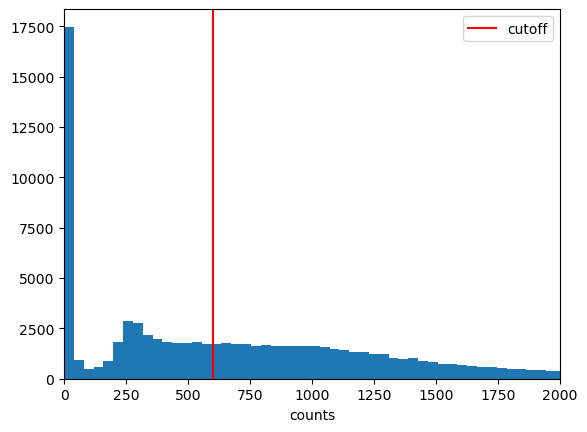

In [18]:
# remove background
cutoff = 600
open_st_mb_rep2_cutoff = open_st_mb_rep2[open_st_mb_rep2.obs.total_counts > cutoff].copy()
plt.hist(open_st_mb_rep2.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 2000])
plt.show()
sc.pl.spatial(open_st_mb_rep2_cutoff, color='total_counts', spot_size=300)

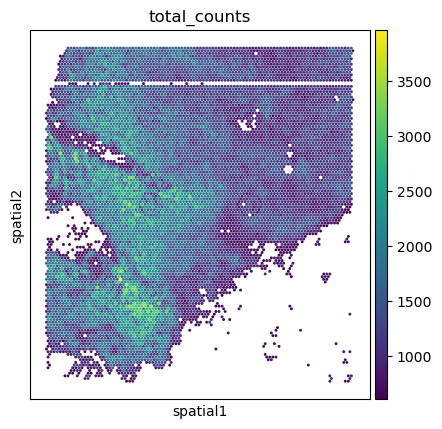

In [19]:
# select field of view
open_st_mb_rep2_left_border = 0
open_st_mb_rep2_right_border = 68000
open_st_mb_rep2_top_border = 1775000
open_st_mb_rep2_bottom_border = 1810000
sc.pl.spatial(open_st_mb_rep2_cutoff[(open_st_mb_rep2_cutoff.obsm['spatial'][:, 0] > open_st_mb_rep2_left_border) &
                                     (open_st_mb_rep2_cutoff.obsm['spatial'][:, 0] < open_st_mb_rep2_right_border) &
                                     (open_st_mb_rep2_cutoff.obsm['spatial'][:, 1] > open_st_mb_rep2_top_border) &
                                     (open_st_mb_rep2_cutoff.obsm['spatial'][:, 1] < open_st_mb_rep2_bottom_border)],
              color='total_counts',
              spot_size=300)

AnnData object with n_obs × n_vars = 9358 × 38704
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'fc_008_L1_tile_2148', 'fc_008_L1_tile_2149', 'fc_008_L1_tile_2150', 'fc_008_L1_tile_2151', 'fc_008_L1_tile_2248', 'fc_008_L1_tile_2249', 'fc_008_L1_tile_2250', 'fc_008_L1_tile_2251'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 38704
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'fc_008_L1_tile_2148', 'fc_008_L1_tile_2149', 'fc_008_L1_tile_2150', 'fc_008_L1_tile_2151', 'fc_008_L1_tile_2248', 'fc_008_L1_tile_2249', 'fc_008_L1_tile_2250', 'fc_008_L1_tile_2251'
    obsm: 'spa

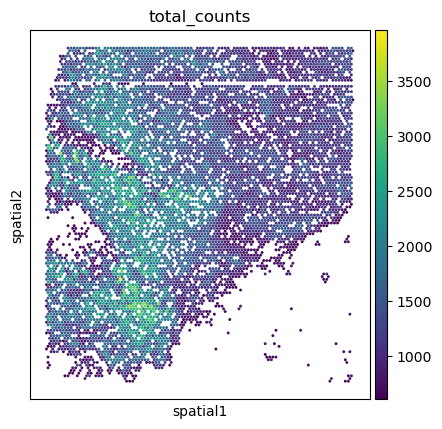

In [20]:
# sample pseudo cells from fov
open_st_mb_rep2_fov = open_st_mb_rep2_cutoff[(open_st_mb_rep2_cutoff.obs.x_pos > open_st_mb_rep2_left_border) &
                                             (open_st_mb_rep2_cutoff.obs.x_pos < open_st_mb_rep2_right_border) &
                                             (open_st_mb_rep2_cutoff.obs.y_pos > open_st_mb_rep2_top_border) &
                                             (open_st_mb_rep2_cutoff.obs.y_pos < open_st_mb_rep2_bottom_border)].copy()
print(open_st_mb_rep2_fov)

rng = np.random.default_rng(RANDOM_SEED)
open_st_mb_rep2_fov_subset = open_st_mb_rep2_fov[rng.choice(open_st_mb_rep2_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(open_st_mb_rep2_fov_subset)

sc.pl.spatial(open_st_mb_rep2_fov_subset, color='total_counts', spot_size=300)

In [21]:
# get barcodes from pseudo cells
open_st_mb_rep2_fov_subset_bcs = []
for pc_index in open_st_mb_rep2_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = open_st_mb_rep2_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    open_st_mb_rep2_fov_subset_bcs.extend(open_st_mb_rep2_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(open_st_mb_rep2_fov_subset_bcs)

1456376

In [22]:
# save barcodes to file
os.makedirs(os.path.dirname('open_st/mouse/e13_rep2/'), exist_ok=True)
with open('open_st/mouse/e13_rep2/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(open_st_mb_rep2_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:open_st/mouse/e13_rep2/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/open_st/processed_data/e13_mouse_rep2/illumina/complete_data/final.polyA_adapter_trimmed.bam  > open_st/mouse/e13_rep2/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o open_st/mouse/e13_rep2/fov_subset_1mm2_area_reads_collated.bam open_st/mouse/e13_rep2/fov_subset_1mm2_area_reads.bam

In [23]:
# create subset files for fov bam
downsampling(base_path='open_st/mouse/e13_rep2/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'open_st/mouse/e13_rep2/fov_subset_1mm2_area_reads_collated.bam'
0it [00:00, ?it/s]

3984134it [00:23, 193182.99it/s]

processed 4000000 reads


7985978it [01:13, 192242.92it/s]

processed 8000000 reads


11990522it [02:31, 196533.95it/s]

processed 12000000 reads


15985298it [04:15, 194221.90it/s]

processed 16000000 reads


19993501it [06:26, 193196.17it/s]

processed 20000000 reads


23984611it [09:05, 190945.30it/s]

processed 24000000 reads


27989183it [12:13, 188524.35it/s]

processed 28000000 reads


31991637it [15:44, 185208.03it/s]

processed 32000000 reads


35998946it [19:47, 186856.91it/s]

processed 36000000 reads


39991238it [24:12, 187521.93it/s]

processed 40000000 reads


40000001it [28:43, 23210.31it/s] 


In [24]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('open_st/mouse/e13_rep2/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'open_st/mouse/e13_rep2/', subset, with_intronic=True)

processing 20M subset
processing 4M subset
processing 8M subset
processing 24M subset
processing 28M subset
processing 40M subset
processing 36M subset
processing 12M subset
processing 32M subset
processing 16M subset


[Wed Mar 27 12:39:55 CET 2024] DigitalExpression --INPUT open_st/mouse/e13_rep2/bam_downsampling/fov_subset_1mm2_area_reads_collated_32M.bam --SUMMARY open_st/mouse/e13_rep2/downsampling_results/with_intronic/dropseqtools_summary_32M.txt --OUTPUT open_st/mouse/e13_rep2/downsampling_results/with_intronic/dropseqtools_dge_32M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE open_st/mouse/e13_rep2/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREAT

In [25]:
# get total genic reads and counts for downsampling data
open_st_mb_rep2_total_counts_40M, open_st_mb_rep2_total_genic_reads_40M = get_genic_reads_and_umis('open_st/mouse/e13_rep2/downsampling_results/with_intronic', 40000000, 10)

In [26]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
if 'with_intronic' not in downsampling_reads_counts.keys():
    downsampling_reads_counts['with_intronic'] = {}
downsampling_reads_counts['with_intronic']['open_st_mb_rep2_40M'] = {}
downsampling_reads_counts['with_intronic']['open_st_mb_rep2_40M']['total_genic_reads'] = open_st_mb_rep2_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['open_st_mb_rep2_40M']['total_counts'] = open_st_mb_rep2_total_counts_40M

with open('/data/rajewsky/home/lstreng/data/paper_benchmark/downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

### human healthy lymph node

In [27]:
open_st_hln = sc.read(f'{spacemake_dir_path}projects/open_st/processed_data/healthy_lymph_node/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].
Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].


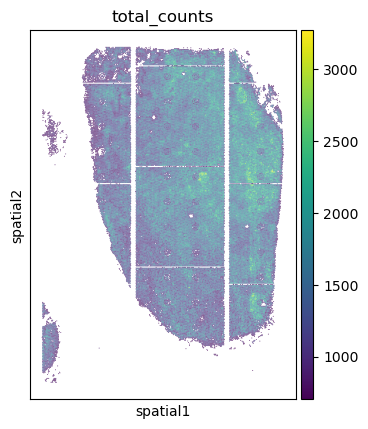

In [28]:
# remove background
cutoff = 700
open_st_hln_cutoff = open_st_hln[open_st_hln.obs.total_counts > cutoff].copy()
plt.hist(open_st_hln.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 2000])
plt.show()
sc.pl.spatial(open_st_hln_cutoff, color='total_counts', spot_size=300)

In [29]:
# select field of view
sc.pl.spatial(open_st_hln_cutoff[(open_st_hln_cutoff.obs.puck_id == 'fc_009_L3a_tile_1223')],
              color='total_counts',
              spot_size=300)

View of AnnData object with n_obs × n_vars = 12715 × 10793
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    var: 'mt'
    uns: 'fc_009_L3a_tile_1121', 'fc_009_L3a_tile_1122', 'fc_009_L3a_tile_1123', 'fc_009_L3a_tile_1124', 'fc_009_L3a_tile_1221', 'fc_009_L3a_tile_1222', 'fc_009_L3a_tile_1223', 'fc_009_L3a_tile_1224', 'fc_009_L3a_tile_1321', 'fc_009_L3a_tile_1322', 'fc_009_L3a_tile_1323', 'fc_009_L3a_tile_1324', 'fc_009_L4b_tile_2541', 'fc_009_L4b_tile_2640', 'fc_009_L4b_tile_2641'
    obsm: 'spatial'


AnnData object with n_obs × n_vars = 7855 × 10793
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    var: 'mt'
    uns: 'fc_009_L3a_tile_1121', 'fc_009_L3a_tile_1122', 'fc_009_L3a_tile_1123', 'fc_009_L3a_tile_1124', 'fc_009_L3a_tile_1221', 'fc_009_L3a_tile_1222', 'fc_009_L3a_tile_1223', 'fc_009_L3a_tile_1224', 'fc_009_L3a_tile_1321', 'fc_009_L3a_tile_1322', 'fc_009_L3a_tile_1323', 'fc_009_L3a_tile_1324', 'fc_009_L4b_tile_2541', 'fc_009_L4b_tile_2640', 'fc_009_L4b_tile_2641'
    obsm: 'spatial'


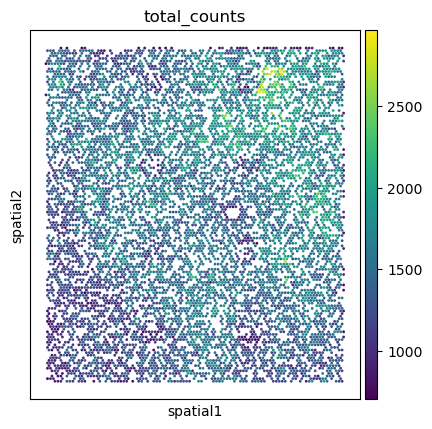

In [30]:
# sample pseudo cells from fov
open_st_hln_fov = open_st_hln_cutoff[(open_st_hln_cutoff.obs.puck_id == 'fc_009_L3a_tile_1223')]
print(open_st_hln_fov)

rng = np.random.default_rng(RANDOM_SEED)
open_st_hln_fov_subset = open_st_hln_fov[rng.choice(open_st_hln_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(open_st_hln_fov_subset)

sc.pl.spatial(open_st_hln_fov_subset, color='total_counts', spot_size=300)

In [31]:
# get barcodes from pseudo cells
open_st_hln_fov_subset_bcs = []
for pc_index in open_st_hln_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = open_st_hln_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    open_st_hln_fov_subset_bcs.extend(open_st_hln_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(open_st_hln_fov_subset_bcs)

1752303

In [34]:
# save barcodes to file
os.makedirs(os.path.dirname('open_st/healthy_lymph_node/'), exist_ok=True)
with open('open_st/healthy_lymph_node/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(open_st_hln_fov_subset_bcs))
    
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:open_st/healthy_lymph_node/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/open_st/processed_data/healthy_lymph_node/illumina/complete_data/final.polyA_adapter_trimmed.bam > open_st/healthy_lymph_node/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o open_st/healthy_lymph_node/fov_subset_1mm2_area_reads_collated.bam open_st/healthy_lymph_node/fov_subset_1mm2_area_reads.bam

In [35]:
# create subset files for fov bam
downsampling(base_path='open_st/healthy_lymph_node/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'open_st/healthy_lymph_node_github/fov_subset_1mm2_area_reads_collated.bam'
3981496it [00:24, 195676.99it/s]

processed 4000000 reads


7992706it [01:14, 202875.09it/s]

processed 8000000 reads


11994117it [02:31, 196629.75it/s]

processed 12000000 reads


15980359it [04:13, 197275.38it/s]

processed 16000000 reads


19988583it [06:21, 192677.32it/s]

processed 20000000 reads


23983489it [08:56, 195516.94it/s]

processed 24000000 reads


27989696it [11:59, 190184.91it/s]

processed 28000000 reads


31991910it [15:24, 185462.04it/s]

processed 32000000 reads


35982953it [19:20, 189246.24it/s]

processed 36000000 reads


39991208it [23:39, 187086.48it/s]

processed 40000000 reads


40000001it [28:02, 23776.83it/s] 


In [36]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('open_st/healthy_lymph_node/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'open_st/healthy_lymph_node/', subset, with_intronic=True)

processing 12M subset
processing 16M subset
processing 40M subset
processing 8M subset
processing 4M subset
processing 32M subset
processing 20M subset
processing 36M subset
processing 24M subset
processing 28M subset


[Wed Mar 27 15:18:10 CET 2024] DigitalExpression --INPUT open_st/healthy_lymph_node_github/bam_downsampling/fov_subset_1mm2_area_reads_collated_4M.bam --SUMMARY open_st/healthy_lymph_node_github/downsampling_results/with_intronic/dropseqtools_summary_4M.txt --OUTPUT open_st/healthy_lymph_node_github/downsampling_results/with_intronic/dropseqtools_dge_4M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE open_st/healthy_lymph_node_github/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_I

In [37]:
# get total genic reads and counts for downsampling data
open_st_hln_total_counts_40M, open_st_hln_total_genic_reads_40M = get_genic_reads_and_umis('open_st/healthy_lymph_node/downsampling_results/with_intronic', 40000000, 10)

In [38]:
# add downsampling results to pickle file
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
downsampling_reads_counts['with_intronic']['open_st_hln_40M'] = {}
downsampling_reads_counts['with_intronic']['open_st_hln_40M']['total_genic_reads'] = open_st_hln_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['open_st_hln_40M']['total_counts'] = open_st_hln_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

### human metastatic lymph node

In [55]:
open_st_mln = sc.read(f'{spacemake_dir_path}projects/open_st/processed_data/metastatic_lymph_node/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

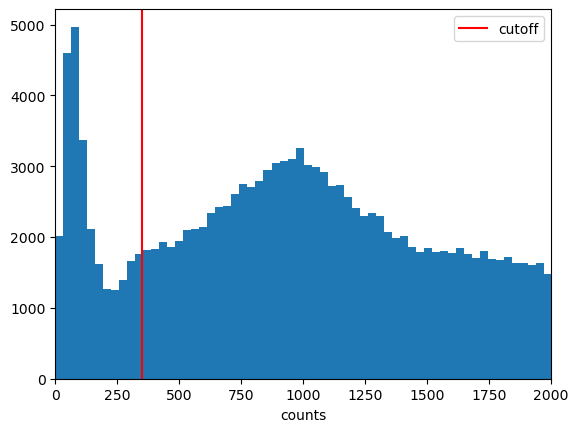

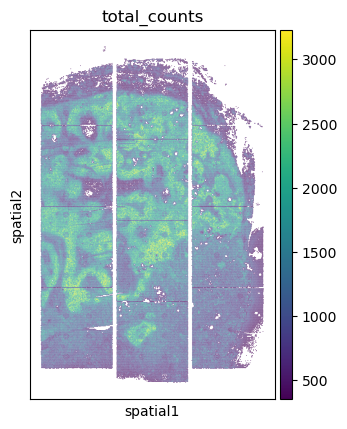

In [56]:
# remove background
cutoff = 350
open_st_mln_cutoff = open_st_mln[open_st_mln.obs.total_counts > cutoff].copy()
plt.hist(open_st_mln.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 2000])
plt.show()
sc.pl.spatial(open_st_mln_cutoff, color='total_counts', spot_size=300)

In [57]:
# select field of view
sc.pl.spatial(open_st_mln_cutoff[(open_st_mln_cutoff.obs.puck_id == 'L3b_tile_2205')],
              color='total_counts',
              spot_size=300)

In [58]:
# sample pseudo cells from fov
open_st_mln_fov = open_st_mln_cutoff[(open_st_mln_cutoff.obs.puck_id == 'L3b_tile_2205')].copy()
print(open_st_mln_fov)

rng = np.random.default_rng(RANDOM_SEED)
open_st_mln_fov_subset = open_st_mln_fov[rng.choice(open_st_mln_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(open_st_mln_fov_subset)

sc.pl.spatial(open_st_mln_fov_subset, color='total_counts', spot_size=300)

AnnData object with n_obs × n_vars = 12825 × 47640
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'L3b_tile_2104', 'L3b_tile_2105', 'L3b_tile_2106', 'L3b_tile_2107', 'L3b_tile_2204', 'L3b_tile_2205', 'L3b_tile_2206', 'L3b_tile_2207', 'L3b_tile_2304', 'L3b_tile_2305', 'L3b_tile_2306', 'L3b_tile_2307'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 47640
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'L3b_tile_2104', 'L3b_tile_2105', 'L3b_tile_2106', 'L3b_tile_2107', 'L3b_tile_2204', 'L3b_tile_2205', 'L3b_tile_2206', 'L3b_tile_2207', 'L3b_tile_2304', 'L3b_tile_2305', 'L3b_t

In [59]:
# get barcodes from pseudo cells
open_st_mln_fov_subset_bcs = []
for pc_index in open_st_mln_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = open_st_mln_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    open_st_mln_fov_subset_bcs.extend(open_st_mln_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(open_st_mln_fov_subset_bcs)

1687789

In [60]:
# save barcodes to file
os.makedirs(os.path.dirname('open_st/metastatic_lymph_node/'), exist_ok=True)
with open('open_st/metastatic_lymph_node/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(open_st_mln_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:open_st/metastatic_lymph_node/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/open_st/processed_data/metastatic_lymph_node/illumina/complete_data/final.polyA_adapter_trimmed.merged.bam > open_st/metastatic_lymph_node/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o open_st/metastatic_lymph_node/fov_subset_1mm2_area_reads_collated.bam open_st/metastatic_lymph_node/fov_subset_1mm2_area_reads.bam

In [61]:
# create subset files for fov bam
downsampling(base_path='open_st/metastatic_lymph_node/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'open_st/metastatic_lymph_node_github/fov_subset_1mm2_area_reads_collated.bam'
3983370it [00:29, 189124.23it/s]

processed 4000000 reads


7987147it [01:22, 193884.59it/s]

processed 8000000 reads


11991074it [02:45, 193208.18it/s]

processed 12000000 reads


15988245it [04:42, 117837.14it/s]

processed 16000000 reads


19998052it [07:04, 193667.32it/s]

processed 20000000 reads


23991419it [09:54, 187049.57it/s]

processed 24000000 reads


27993601it [13:16, 182285.23it/s]

processed 28000000 reads


31988181it [17:09, 183131.85it/s]

processed 32000000 reads


35986121it [21:30, 184608.67it/s]

processed 36000000 reads


39988982it [26:15, 180604.66it/s]

processed 40000000 reads


40000001it [31:13, 21353.18it/s] 


In [62]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('open_st/metastatic_lymph_node/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'open_st/metastatic_lymph_node/', subset, with_intronic=True)

processing 28M subset
processing 4M subset
processing 32M subset
processing 20M subset
processing 8M subset
processing 12M subset
processing 16M subset
processing 24M subset
processing 40M subset
processing 36M subset


[Wed Mar 27 18:12:30 CET 2024] DigitalExpression --INPUT open_st/metastatic_lymph_node_github/bam_downsampling/fov_subset_1mm2_area_reads_collated_4M.bam --SUMMARY open_st/metastatic_lymph_node_github/downsampling_results/with_intronic/dropseqtools_summary_4M.txt --OUTPUT open_st/metastatic_lymph_node_github/downsampling_results/with_intronic/dropseqtools_dge_4M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE open_st/metastatic_lymph_node_github/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --M

In [63]:
# get total genic reads and counts for downsampling data
open_st_mln_total_counts_40M, open_st_mln_total_genic_reads_40M = get_genic_reads_and_umis('open_st/metastatic_lymph_node/downsampling_results/with_intronic', 40000000, 10)

In [64]:
# add downsampling results to pickle file
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
downsampling_reads_counts['with_intronic']['open_st_mln_40M'] = {}
downsampling_reads_counts['with_intronic']['open_st_mln_40M']['total_genic_reads'] = open_st_mln_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['open_st_mln_40M']['total_counts'] = open_st_mln_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

### primary tumor

In [65]:
open_st_primary = sc.read(f'{spacemake_dir_path}projects/open_st/processed_data/primary_tumor/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

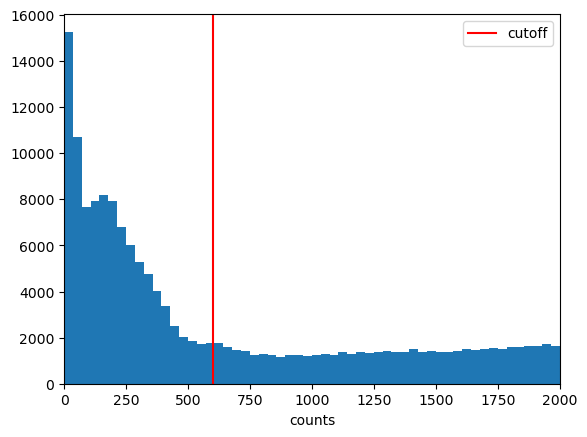

In [66]:
# remove background
cutoff = 600
open_st_primary_cutoff = open_st_primary[open_st_primary.obs.total_counts > cutoff].copy()
plt.hist(open_st_primary.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 2000])
plt.show()
sc.pl.spatial(open_st_primary_cutoff, color='total_counts', spot_size=300)

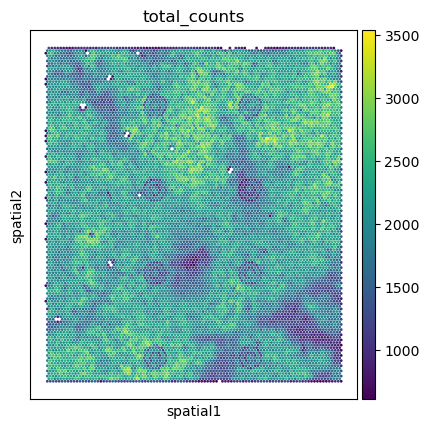

In [67]:
# select field of view
sc.pl.spatial(open_st_primary_cutoff[open_st_primary_cutoff.obs.puck_id == 'L4b_tile_2640'],
              color='total_counts',
              spot_size=300)

AnnData object with n_obs × n_vars = 12921 × 47398
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'L4b_tile_2438', 'L4b_tile_2439', 'L4b_tile_2440', 'L4b_tile_2441', 'L4b_tile_2442', 'L4b_tile_2538', 'L4b_tile_2539', 'L4b_tile_2540', 'L4b_tile_2541', 'L4b_tile_2542', 'L4b_tile_2638', 'L4b_tile_2639', 'L4b_tile_2640', 'L4b_tile_2641', 'L4b_tile_2642'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 47398
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'L4b_tile_2438', 'L4b_tile_2439', 'L4b_tile_2440', 'L4b_tile_2441', 'L4b_tile_2442', 'L4b_tile_2538', 'L4b_tile_2539', 'L4b_t

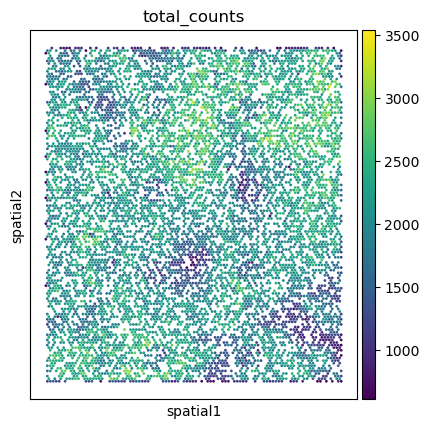

In [68]:
# sample pseudo cells from fov
open_st_primary_fov = open_st_primary_cutoff[open_st_primary_cutoff.obs.puck_id == 'L4b_tile_2640'].copy()
print(open_st_primary_fov)

rng = np.random.default_rng(RANDOM_SEED)
open_st_primary_fov_subset = open_st_primary_fov[rng.choice(open_st_primary_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(open_st_primary_fov_subset)

sc.pl.spatial(open_st_primary_fov_subset, color='total_counts', spot_size=300)

In [69]:
# get barcodes from pseudo cells
open_st_primary_fov_subset_bcs = []
for pc_index in open_st_primary_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = open_st_primary_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    open_st_primary_fov_subset_bcs.extend(open_st_primary_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(open_st_primary_fov_subset_bcs)

1735361

In [70]:
# save barcodes to file
os.makedirs(os.path.dirname('open_st/primary_tumor/'), exist_ok=True)
with open('open_st/primary_tumor/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(open_st_primary_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:open_st/primary_tumor/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/open_st/processed_data/primary_tumor/illumina/complete_data/final.polyA_adapter_trimmed.merged.bam > open_st/primary_tumor/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o open_st/primary_tumor/fov_subset_1mm2_area_reads_collated.bam open_st/primary_tumor/fov_subset_1mm2_area_reads.bam

In [71]:
# create subset files for fov bam
downsampling(base_path='open_st/primary_tumor/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'open_st/primary_tumor_github/fov_subset_1mm2_area_reads_collated.bam'
3993921it [00:30, 190165.15it/s]

processed 4000000 reads


7983083it [01:32, 191023.67it/s]

processed 8000000 reads


11984161it [02:59, 63205.70it/s] 

processed 12000000 reads


15990298it [04:53, 185020.08it/s]

processed 16000000 reads


19995810it [07:16, 165439.06it/s]

processed 20000000 reads


23987378it [10:06, 165307.18it/s]

processed 24000000 reads


27984284it [13:22, 162821.67it/s]

processed 28000000 reads


31997374it [17:11, 152766.58it/s]

processed 32000000 reads


35995441it [21:19, 165105.61it/s]

processed 36000000 reads


39988845it [25:57, 168924.06it/s]

processed 40000000 reads


40000001it [30:36, 21780.12it/s] 


In [72]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('open_st/primary_tumor/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'open_st/primary_tumor/', subset, with_intronic=True)

processing 40M subset
processing 12M subset
processing 8M subset
processing 16M subset
processing 36M subset
processing 32M subset
processing 4M subset
processing 20M subset
processing 24M subset
processing 28M subset


[Wed Mar 27 21:23:47 CET 2024] DigitalExpression --INPUT open_st/primary_tumor_github/bam_downsampling/fov_subset_1mm2_area_reads_collated_8M.bam --SUMMARY open_st/primary_tumor_github/downsampling_results/with_intronic/dropseqtools_summary_8M.txt --OUTPUT open_st/primary_tumor_github/downsampling_results/with_intronic/dropseqtools_dge_8M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE open_st/primary_tumor_github/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREAT

In [73]:
# get total genic reads and counts for downsampling data
open_st_primary_total_counts_40M, open_st_primary_total_genic_reads_40M = get_genic_reads_and_umis('open_st/primary_tumor/downsampling_results/with_intronic', 40000000, 10)

In [74]:
# add downsampling results to pickle file
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
downsampling_reads_counts['with_intronic']['open_st_primary_40M'] = {}
downsampling_reads_counts['with_intronic']['open_st_primary_40M']['total_genic_reads'] = open_st_primary_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['open_st_primary_40M']['total_counts'] = open_st_primary_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

## Seq-Scope

In [90]:
seq_scope = sc.read(f'{spacemake_dir_path}projects/seq_scope/processed_data/mouse_liver/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads.mesh_7_hexagon_puck_collection.h5ad')

Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].
Only considering the two last: ['.mesh_7_hexagon_puck_collection', '.h5ad'].


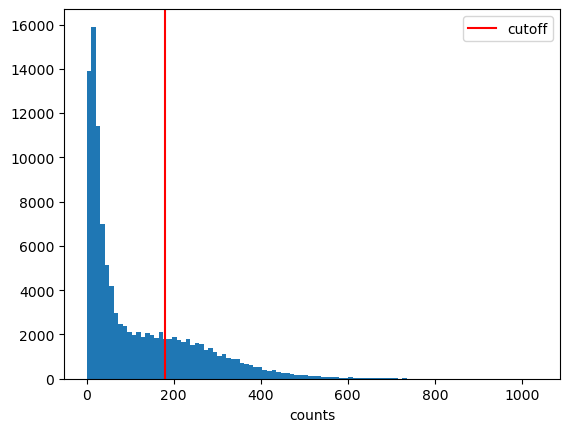

In [91]:
# remove background
cutoff = 180
seq_scope_cutoff = seq_scope[seq_scope.obs.total_counts > cutoff].copy()
plt.hist(seq_scope.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.show()
sc.pl.spatial(seq_scope_cutoff, color='total_counts', spot_size=300)

In [92]:
# select field of view
seq_scope_top_border = 90000
seq_scope_bottom_border = 250000
sc.pl.spatial(seq_scope_cutoff[(seq_scope_cutoff.obsm['spatial'][:, 1] > seq_scope_top_border) &
                               (seq_scope_cutoff.obsm['spatial'][:, 1] < seq_scope_bottom_border)],
              color='total_counts',
              spot_size=300)

View of AnnData object with n_obs × n_vars = 10740 × 35295
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'tile_2101_coords', 'tile_2102_coords', 'tile_2103_coords', 'tile_2104_coords', 'tile_2105_coords', 'tile_2106_coords', 'tile_2107_coords', 'tile_2108_coords', 'tile_2109_coords', 'tile_2110_coords', 'tile_2111_coords', 'tile_2112_coords', 'tile_2113_coords', 'tile_2114_coords', 'tile_2115_coords', 'tile_2116_coords', 'tile_2117_coords', 'tile_2118_coords', 'tile_2119_coords'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 35295
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
 

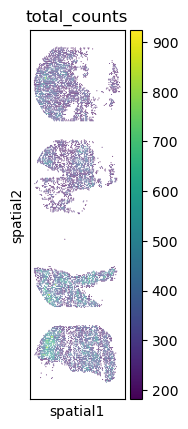

In [93]:
# sample pseudo cells from fov
seq_scope_fov = seq_scope_cutoff[(seq_scope_cutoff.obsm['spatial'][:, 1] > seq_scope_top_border) &
                                 (seq_scope_cutoff.obsm['spatial'][:, 1] < seq_scope_bottom_border)]
print(seq_scope_fov)

rng = np.random.default_rng(RANDOM_SEED)
seq_scope_fov_subset = seq_scope_fov[rng.choice(seq_scope_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(seq_scope_fov_subset)

sc.pl.spatial(seq_scope_fov_subset, color='total_counts', spot_size=300)

In [94]:
# get barcodes from pseudo cells
seq_scope_fov_subset_bcs = []
for pc_index in seq_scope_fov_subset.obs.index:
    n, tile = pc_index.split(':')
    inds = seq_scope_fov_subset.uns[tile]['indices_joined_spatial_units'][int(n)].nonzero()[1]
    seq_scope_fov_subset_bcs.extend(seq_scope_fov_subset.uns[tile]['spatial_units_obs_names'][inds])
len(seq_scope_fov_subset_bcs)

1040843

In [95]:
# save barcodes to file
os.makedirs(os.path.dirname('seq_scope/mouse_liver/'), exist_ok=True)
with open('seq_scope/mouse_liver/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(seq_scope_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:seq_scope/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/seq_scope/processed_data/mouse_liver/illumina/complete_data/final.polyA_adapter_trimmed.bam > seq_scope/mouse_liver/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o seq_scope/mouse_liver/fov_subset_1mm2_area_reads_collated.bam seq_scope/mouse_liver/fov_subset_1mm2_area_reads.bam

In [96]:
# create subset files for fov bam
downsampling(base_path='seq_scope/mouse_liver/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'seq_scope/mouse_liver/fov_subset_1mm2_area_reads_collated.bam'
187694it [00:01, 172993.21it/s]

3989865it [00:29, 183420.91it/s]

processed 4000000 reads


7985355it [01:26, 187675.69it/s]

processed 8000000 reads


11998135it [02:48, 190131.93it/s]

processed 12000000 reads


15985753it [04:44, 182794.80it/s]

processed 16000000 reads


17115613it [06:49, 41829.74it/s] 


In [97]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('seq_scope/mouse_liver/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'seq_scope/mouse_liver/', subset, with_intronic=True)

processing 16M subset
processing 8M subset
processing 12M subset
processing 4M subset


[Thu Mar 28 14:42:55 CET 2024] DigitalExpression --INPUT seq_scope/mouse_liver/bam_downsampling/fov_subset_1mm2_area_reads_collated_4M.bam --SUMMARY seq_scope/mouse_liver/downsampling_results/with_intronic/dropseqtools_summary_4M.txt --OUTPUT seq_scope/mouse_liver/downsampling_results/with_intronic/dropseqtools_dge_4M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE seq_scope/mouse_liver/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREATE_MD5_F

In [98]:
# get total genic reads and counts for downsampling data
seq_scope_total_counts_40M, seq_scope_total_genic_reads_40M = get_genic_reads_and_umis('seq_scope/mouse_liver/downsampling_results/with_intronic', 40000000, 10)

In [99]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)

downsampling_reads_counts['with_intronic']['seq_scope_40M'] = {}    
downsampling_reads_counts['with_intronic']['seq_scope_40M']['total_genic_reads'] = seq_scope_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['seq_scope_40M']['total_counts'] = seq_scope_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

## Stereo-seq

In [75]:
from spacemake.spatial import puck_collection
from spacemake.spatial.util import create_meshed_adata

In [76]:
# do stitching and meshing 'manually' because spacemake meshes get to big
# stitch single spot files
puck_paths = [f'{spacemake_dir_path}projects/stereo_seq/processed_data/adult_mouse_brain/illumina/complete_data/dge/' + f 
              for f in os.listdir(f'{spacemake_dir_path}projects/stereo_seq/processed_data/adult_mouse_brain/illumina/complete_data/dge/') 
              if f.endswith('.h5ad') and 'spatial_beads_' in f]
puck_ids = [f.split('/')[-1][-22:-5] for f in puck_paths]
stereo_seq_single_spot = puck_collection.merge_pucks_to_collection(puck_paths,
                                                                   puck_ids,
                                                                   f'{spacemake_dir_path}puck_data/stereo_seq_coordinate_system.csv',
                                                                   '',
                                                                   'puck_id'
                                                                   )
stereo_seq_single_spot

/data/rajewsky/home/lstreng/miniconda_new/envs/benchmark_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 160685362 × 39360
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos', 'puck_id'
    uns: 'split_barcodes_13', 'split_barcodes_23', 'split_barcodes_12', 'split_barcodes_22', 'split_barcodes_40', 'split_barcodes_41', 'split_barcodes_16', 'split_barcodes_26', 'split_barcodes_17', 'split_barcodes_27', 'split_barcodes_45', 'split_barcodes_44', 'split_barcodes_33', 'split_barcodes_48', 'split_barcodes_32', 'split_barcodes_49', 'split_barcodes_50', 'split_barcodes_51', 'split_barcodes_36', 'split_barcodes_06', 'split_barcodes_37', 'split_barcodes_07', 'split_barcodes_55', 'split_barcodes_54', 'split_barcodes_30', 'split_barcodes_31', 'split_barcodes_28', 'split_barcodes_18', 'split_barcodes_53', 'split_barcodes_29', 'split_barcodes_52', 'split_barcodes_19', 'split_barcodes_35', 'split_barcode

In [77]:
# bin data to pseudo cells
stereo_seq_meshed = create_meshed_adata(
    adata=stereo_seq_single_spot,
    px_by_um=2,
    spot_diameter_um = 7,
    spot_distance_um = 7,
    bead_diameter_um = 0.5,
    mesh_type = 'hexagon',
    start_at_minimum=False,
    optimized_binning=True #False
)
stereo_seq_meshed

/data/rajewsky/home/lstreng/miniconda_new/envs/benchmark_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 160685362 × 39360
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos', 'puck_id'
    uns: 'split_barcodes_13', 'split_barcodes_23', 'split_barcodes_12', 'split_barcodes_22', 'split_barcodes_40', 'split_barcodes_41', 'split_barcodes_16', 'split_barcodes_26', 'split_barcodes_17', 'split_barcodes_27', 'split_barcodes_45', 'split_barcodes_44', 'split_barcodes_33', 'split_barcodes_48', 'split_barcodes_32', 'split_barcodes_49', 'split_barcodes_50', 'split_barcodes_51', 'split_barcodes_36', 'split_barcodes_06', 'split_barcodes_37', 'split_barcodes_07', 'split_barcodes_55', 'split_barcodes_54', 'split_barcodes_30', 'split_barcodes_31', 'split_barcodes_28', 'split_barcodes_18', 'split_barcodes_53', 'split_barcodes_29', 'split_barcodes_52', 'split_barcodes_19', 'split_barcodes_35', 'split_barcode

AnnData object with n_obs × n_vars = 666435 × 39360
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial_units_obs_names', 'indices_joined_spatial_units'
    obsm: 'spatial'

/data/rajewsky/home/lstreng/miniconda_new/envs/benchmark_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/rajewsky/home/lstreng/miniconda_new/envs/benchmark_paper/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


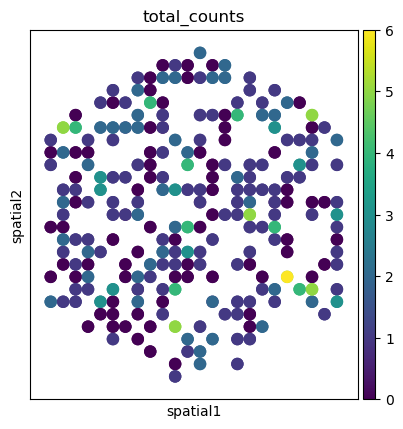

In [78]:
# 15 spots per side with 0.5um center to center distance -> 7um side length
pseudo_cell = stereo_seq_single_spot[stereo_seq_meshed.uns['indices_joined_spatial_units'][450000].nonzero()[1]]
sc.pl.spatial(pseudo_cell, spot_size=1, color='total_counts')

In [79]:
os.makedirs(os.path.dirname('stereo_seq/adult_mouse_brain/'), exist_ok=True)
stereo_seq_meshed.write('stereo_seq/adult_mouse_brain/correctly_meshed_adata.h5ad')

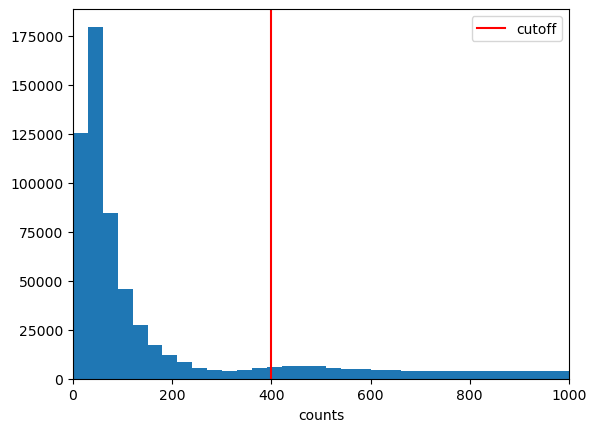

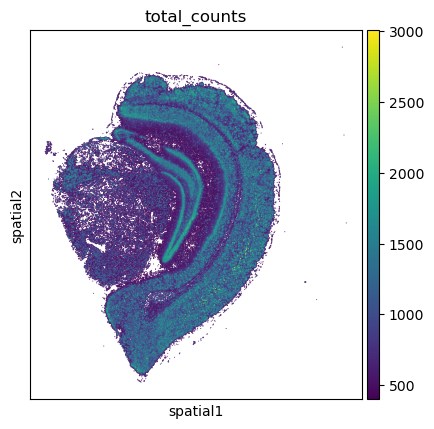

AnnData object with n_obs × n_vars = 139856 × 39360
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial_units_obs_names', 'indices_joined_spatial_units'
    obsm: 'spatial'


In [80]:
# remove background
cutoff = 400
stereo_seq_cutoff = stereo_seq_meshed[stereo_seq_meshed.obs.total_counts > cutoff].copy()
plt.hist(stereo_seq_meshed.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 1000])
plt.show()
sc.pl.spatial(stereo_seq_cutoff, color='total_counts', spot_size=40)
print(stereo_seq_cutoff)

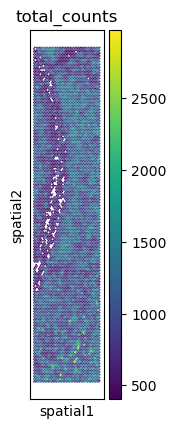

In [81]:
# select field of view
stereo_seq_left_border = 49500
stereo_seq_right_border = 50500
stereo_seq_top_border = 9500
stereo_seq_bottom_border = 14500
sc.pl.spatial(stereo_seq_cutoff[(stereo_seq_cutoff.obs.x_pos > stereo_seq_left_border) &
                                (stereo_seq_cutoff.obs.x_pos < stereo_seq_right_border) &
                                (stereo_seq_cutoff.obs.y_pos > stereo_seq_top_border) &
                                (stereo_seq_cutoff.obs.y_pos < stereo_seq_bottom_border)],
              color='total_counts',
              spot_size=25)

AnnData object with n_obs × n_vars = 9566 × 39360
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial_units_obs_names', 'indices_joined_spatial_units'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 7855 × 39360
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial_units_obs_names', 'indices_joined_spatial_units'
    obsm: 'spatial'


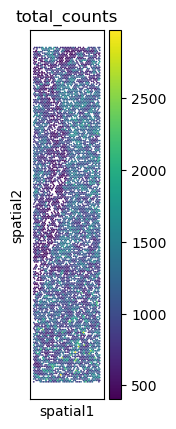

In [82]:
# sample pseudo cells from fov
stereo_seq_fov = stereo_seq_cutoff[(stereo_seq_cutoff.obs.x_pos > stereo_seq_left_border) &
                                   (stereo_seq_cutoff.obs.x_pos < stereo_seq_right_border) &
                                   (stereo_seq_cutoff.obs.y_pos > stereo_seq_top_border) &
                                   (stereo_seq_cutoff.obs.y_pos < stereo_seq_bottom_border)].copy()
print(stereo_seq_fov)

rng = np.random.default_rng(RANDOM_SEED)
stereo_seq_fov_subset = stereo_seq_fov[rng.choice(stereo_seq_fov.n_obs, size=n_pseudo_cells, replace=False)].copy()
print(stereo_seq_fov_subset)

sc.pl.spatial(stereo_seq_fov_subset, color='total_counts', spot_size=25)

In [83]:
# get barcodes from pseudo cells
stereo_seq_fov_subset_bcs = []
for cell_index in stereo_seq_fov_subset.obs.index:
    inds = stereo_seq_fov_subset.uns['indices_joined_spatial_units'][int(cell_index)].nonzero()[1]
    stereo_seq_fov_subset_bcs.extend(stereo_seq_fov_subset.uns['spatial_units_obs_names'][inds])
stereo_seq_fov_subset_bcs = [i.split(':')[0] for i in stereo_seq_fov_subset_bcs]
len(stereo_seq_fov_subset_bcs)

4849270

In [84]:
# save barcodes to file
os.makedirs(os.path.dirname('stereo_seq/adult_mouse_brain/'), exist_ok=True)
with open(f'stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(stereo_seq_fov_subset_bcs))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/stereo_seq/processed_data/adult_mouse_brain/illumina/complete_data/final.polyA_adapter_trimmed.bam  > stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_reads_collated.bam stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_reads.bam

In [86]:
# create subset files for fov bam
downsampling(base_path='stereo_seq/adult_mouse_brain/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_reads_collated.bam'
0it [00:00, ?it/s]

3998942it [00:34, 176545.19it/s]

processed 4000000 reads


7993241it [01:38, 166461.24it/s]

processed 8000000 reads


11996493it [03:18, 160570.43it/s]

processed 12000000 reads


15990990it [05:33, 114268.70it/s]

processed 16000000 reads


19992757it [08:22, 161695.22it/s]

processed 20000000 reads


23997172it [11:47, 164120.70it/s]

processed 24000000 reads


27985254it [15:48, 158916.58it/s]

processed 28000000 reads


31984737it [20:19, 159686.04it/s]

processed 32000000 reads


35983525it [25:30, 181717.63it/s]

processed 36000000 reads


39984973it [31:10, 180074.02it/s]

processed 40000000 reads


40000001it [37:01, 18004.22it/s] 


In [87]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('stereo_seq/adult_mouse_brain/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'stereo_seq/adult_mouse_brain/', subset, with_intronic=True)

processing 4M subset
processing 12M subset
processing 32M subset
processing 16M subset
processing 8M subset
processing 36M subset
processing 40M subset
processing 28M subset
processing 20M subset
processing 24M subset


[Thu Mar 28 11:52:34 CET 2024] DigitalExpression --INPUT stereo_seq/adult_mouse_brain/bam_downsampling/fov_subset_1mm2_area_reads_collated_20M.bam --SUMMARY stereo_seq/adult_mouse_brain/downsampling_results/with_intronic/dropseqtools_summary_20M.txt --OUTPUT stereo_seq/adult_mouse_brain/downsampling_results/with_intronic/dropseqtools_dge_20M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE stereo_seq/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CR

In [88]:
# get total genic reads and counts for downsampling data
stereo_seq_total_counts_40M, stereo_seq_total_genic_reads_40M = get_genic_reads_and_umis('stereo_seq/adult_mouse_brain/downsampling_results/with_intronic', 40000000, 10)

In [89]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)

downsampling_reads_counts['with_intronic']['stereo_seq_40M'] = {}    
downsampling_reads_counts['with_intronic']['stereo_seq_40M']['total_genic_reads'] = stereo_seq_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['stereo_seq_40M']['total_counts'] = stereo_seq_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

## Slide-seq

In [101]:
slide_seq = sc.read(f'{spacemake_dir_path}projects/slide_seqv2/processed_data/e9_5_mouse/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads_GSM5915059_201104_36_matched_bead_locations_new.h5ad')

Only considering the two last: ['.spatial_beads_GSM5915059_201104_36_matched_bead_locations_new', '.h5ad'].
Only considering the two last: ['.spatial_beads_GSM5915059_201104_36_matched_bead_locations_new', '.h5ad'].


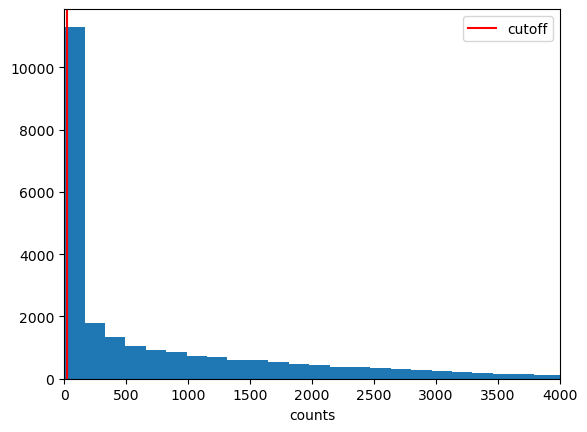

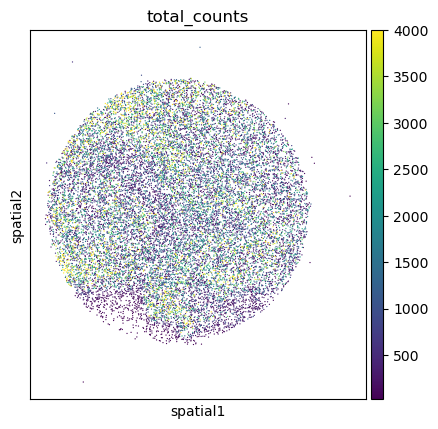

In [102]:
# remove background and low quality beads
cutoff = 20
slide_seq_cutoff = slide_seq[slide_seq.obs.total_counts > cutoff].copy()
plt.hist(slide_seq.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 4000])
plt.show()
sc.pl.spatial(slide_seq_cutoff, color='total_counts', spot_size=20, vmax=4000)

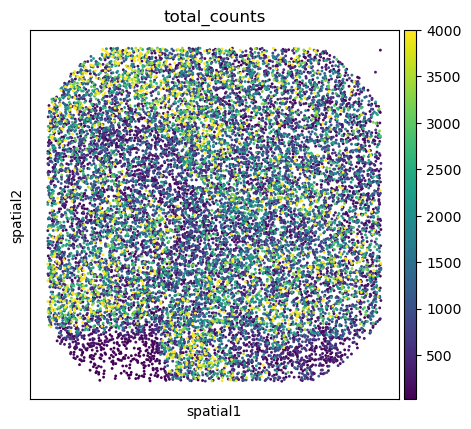

In [103]:
# select field of view
slide_seq_left_border = 1800
slide_seq_right_border = 5300
slide_seq_top_border = 2000
slide_seq_bottom_border = 5500
sc.pl.spatial(slide_seq_cutoff[(slide_seq_cutoff.obs.x_pos > slide_seq_left_border) &
                               (slide_seq_cutoff.obs.x_pos < slide_seq_right_border) &
                               (slide_seq_cutoff.obs.y_pos > slide_seq_top_border) &
                               (slide_seq_cutoff.obs.y_pos < slide_seq_bottom_border)],
              color='total_counts',
              spot_size=30,
              vmax=4000)

AnnData object with n_obs × n_vars = 14430 × 28987
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 12738 × 28987
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'


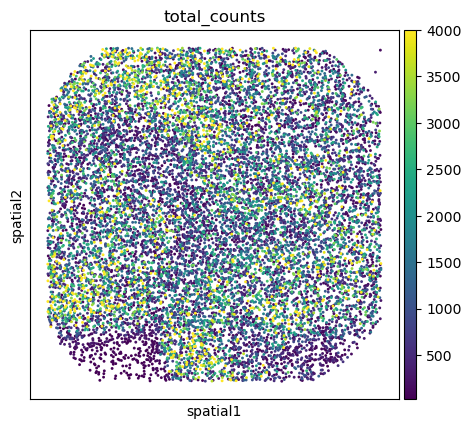

In [104]:
# sample beads from fov
slide_seq_fov = slide_seq_cutoff[(slide_seq_cutoff.obs.x_pos > slide_seq_left_border) &
                                 (slide_seq_cutoff.obs.x_pos < slide_seq_right_border) &
                                 (slide_seq_cutoff.obs.y_pos > slide_seq_top_border) &
                                 (slide_seq_cutoff.obs.y_pos < slide_seq_bottom_border)].copy()
print(slide_seq_fov)

rng = np.random.default_rng(RANDOM_SEED)
slide_seq_fov_subset = slide_seq_fov[rng.choice(slide_seq_fov.n_obs, size=n_spots_slide_seq, replace=False)].copy()
print(slide_seq_fov_subset)

sc.pl.spatial(slide_seq_fov_subset, color='total_counts', spot_size=30, vmax=4000)

In [105]:
# save barcodes of beads to file
os.makedirs(os.path.dirname('slide_seqv2/e9_5_mouse/'), exist_ok=True)
with open('slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(slide_seq_fov_subset.obs_names))
    
# save reads of barcodes in file to new bam
!samtools view -b -D CB:slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/slide_seqv2/processed_data/e9_5_mouse/illumina/complete_data/final.polyA_adapter_trimmed.bam  > slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_reads.bam

# shuffle reads
!samtools collate -o slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_reads_collated.bam slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_reads.bam

In [107]:
# create subset files for fov bam
downsampling(base_path='slide_seqv2/e9_5_mouse/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_reads_collated.bam'
0it [00:00, ?it/s]

3990246it [00:26, 94773.90it/s] 

processed 4000000 reads


7999664it [01:14, 202037.63it/s]

processed 8000000 reads


11994076it [02:25, 186439.04it/s]

processed 12000000 reads


15987133it [03:53, 197133.65it/s]

processed 16000000 reads


19986593it [05:44, 197903.98it/s]

processed 20000000 reads


23989655it [07:59, 189768.44it/s]

processed 24000000 reads


27995576it [10:32, 195730.52it/s]

processed 28000000 reads


31994592it [13:28, 199098.67it/s]

processed 32000000 reads


35999790it [16:47, 194748.74it/s]

processed 36000000 reads


39986459it [20:30, 196798.54it/s]

processed 40000000 reads


40000001it [24:09, 27593.26it/s] 


In [108]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('slide_seqv2/e9_5_mouse/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'slide_seqv2/e9_5_mouse/', subset, with_intronic=True)

processing 32M subset
processing 40M subset
processing 12M subset
processing 16M subset
processing 20M subset
processing 24M subset
processing 36M subset
processing 4M subset
processing 28M subset
processing 8M subset


[Thu Mar 28 16:43:17 CET 2024] DigitalExpression --INPUT slide_seqv2/e9_5_mouse/bam_downsampling/fov_subset_1mm2_area_reads_collated_28M.bam --SUMMARY slide_seqv2/e9_5_mouse/downsampling_results/with_intronic/dropseqtools_summary_28M.txt --OUTPUT slide_seqv2/e9_5_mouse/downsampling_results/with_intronic/dropseqtools_dge_28M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE slide_seqv2/e9_5_mouse/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false --CREAT

In [109]:
# get total genic reads and counts for downsampling data
slide_seq_total_counts_40M, slide_seq_total_genic_reads_40M = get_genic_reads_and_umis(base_path='slide_seqv2/e9_5_mouse/downsampling_results/with_intronic', max_reads=40000000, steps=10)

In [110]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)

downsampling_reads_counts['with_intronic']['slide_seq_40M'] = {}
downsampling_reads_counts['with_intronic']['slide_seq_40M']['total_genic_reads'] = slide_seq_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['slide_seq_40M']['total_counts'] = slide_seq_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

## Visium

In [111]:
visium = sc.read(f'{spacemake_dir_path}projects/visium/processed_data/adult_mouse_brain/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads_barcode_locations_corrected.h5ad')

Only considering the two last: ['.spatial_beads_barcode_locations_corrected', '.h5ad'].
Only considering the two last: ['.spatial_beads_barcode_locations_corrected', '.h5ad'].


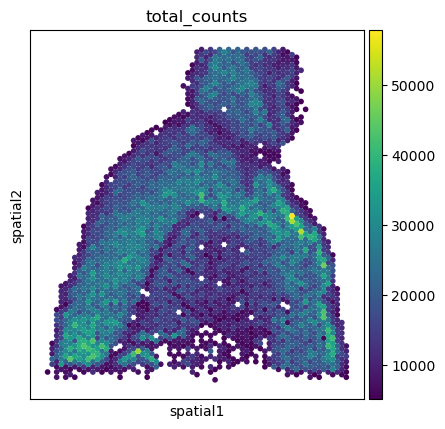

In [112]:
# remove background 
cutoff = 5000
visium_cutoff = visium[visium.obs.total_counts > cutoff].copy()
plt.hist(visium.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 40000])
plt.show()
sc.pl.spatial(visium_cutoff, color='total_counts', spot_size=150)

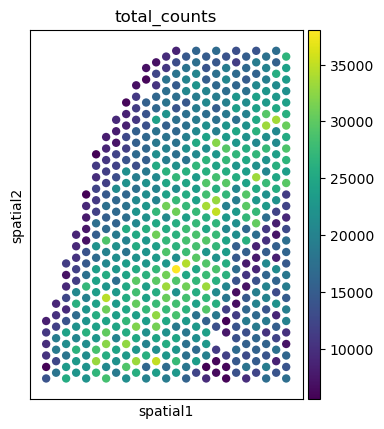

In [113]:
# select field of view
visium_left_border = 2500
visium_right_border = 5500
visium_top_border = 4500
visium_bottom_border = 8500
sc.pl.spatial(visium_cutoff[(visium_cutoff.obs.x_pos > visium_left_border) &
                            (visium_cutoff.obs.x_pos < visium_right_border) &
                            (visium_cutoff.obs.y_pos > visium_top_border) &
                            (visium_cutoff.obs.y_pos < visium_bottom_border)],
              color='total_counts',
              spot_size=100)

View of AnnData object with n_obs × n_vars = 600 × 30597
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 420 × 30597
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'


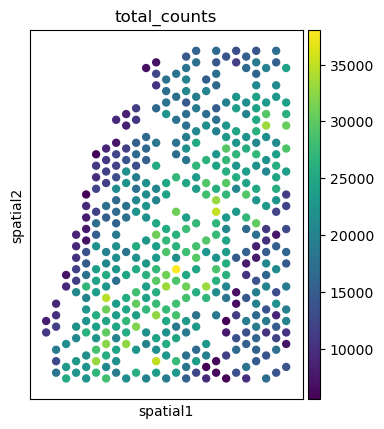

In [114]:
# sample pseudo cells from fov
visium_fov_area = visium_cutoff[(visium_cutoff.obs.x_pos > visium_left_border) &
                                (visium_cutoff.obs.x_pos < visium_right_border) &
                                (visium_cutoff.obs.y_pos > visium_top_border) &
                                (visium_cutoff.obs.y_pos < visium_bottom_border)]
print(visium_fov_area)

rng = np.random.default_rng(RANDOM_SEED)
visium_fov_subset = visium_fov_area[rng.choice(visium_fov_area.n_obs, size=n_visium_spots, replace=False)].copy()
print(visium_fov_subset)

sc.pl.spatial(visium_fov_subset, color='total_counts', spot_size=100)

In [115]:
# save barcodes of spots to file
os.makedirs(os.path.dirname('visium/adult_mouse_brain/'), exist_ok=True)
with open('visium/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(visium_fov_subset.obs_names))

#save reads of barcodes in file to new bam
!samtools view -b -D CB:visium/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/visium/processed_data/adult_mouse_brain/illumina/complete_data/final.polyA_adapter_trimmed.bam  > visium/adult_mouse_brain/fov_subset_1mm2_area_reads.bam

#shuffle reads
!samtools collate -o visium/adult_mouse_brain/fov_subset_1mm2_area_reads_collated.bam visium/adult_mouse_brain/fov_subset_1mm2_area_reads.bam

In [116]:
# create subset files for fov bam
downsampling(base_path='visium/adult_mouse_brain/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'visium/adult_mouse_brain/fov_subset_1mm2_area_reads_collated.bam'
0it [00:00, ?it/s]

3991561it [00:22, 59201.07it/s] 

processed 4000000 reads


7982263it [01:19, 192979.63it/s]

processed 8000000 reads


11997772it [02:46, 190806.52it/s]

processed 12000000 reads


15984692it [04:42, 178145.84it/s]

processed 16000000 reads


19996202it [07:06, 190611.13it/s]

processed 20000000 reads


23986139it [10:03, 189544.05it/s]

processed 24000000 reads


27994026it [13:30, 13900.15it/s] 

processed 28000000 reads


31993983it [17:23, 187907.58it/s]

processed 32000000 reads


35981545it [21:52, 187922.27it/s]

processed 36000000 reads


39987042it [26:42, 186060.65it/s]

processed 40000000 reads


40000001it [31:38, 21071.56it/s] 


In [117]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('visium/adult_mouse_brain/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'visium/adult_mouse_brain/', subset, with_intronic=True)

processing 12M subset
processing 40M subset
processing 32M subset
processing 4M subset
processing 8M subset
processing 36M subset
processing 16M subset
processing 20M subset
processing 24M subset
processing 28M subset


[Thu Mar 28 17:46:34 CET 2024] DigitalExpression --INPUT visium/adult_mouse_brain/bam_downsampling/fov_subset_1mm2_area_reads_collated_36M.bam --SUMMARY visium/adult_mouse_brain/downsampling_results/with_intronic/dropseqtools_summary_36M.txt --OUTPUT visium/adult_mouse_brain/downsampling_results/with_intronic/dropseqtools_dge_36M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE visium/adult_mouse_brain/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false

In [118]:
# get total genic reads and counts for downsampling data
visium_total_counts_40M, visium_total_genic_reads_40M = get_genic_reads_and_umis('visium/adult_mouse_brain/downsampling_results/with_intronic', 40000000, 10)

In [119]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)

downsampling_reads_counts['with_intronic']['visium_40M'] = {}
downsampling_reads_counts['with_intronic']['visium_40M']['total_genic_reads'] = visium_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['visium_40M']['total_counts'] = visium_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

## DBiT-seq

In [120]:
dbit_seq = sc.read_h5ad(f'{spacemake_dir_path}projects/dbit_seq/processed_data/e11_25um/illumina/complete_data/dge/dge.all.polyA_adapter_trimmed.mm_included.spatial_beads_GSE137986_barcodes.h5ad')

In [121]:
# remove background 
cutoff = 800
dbit_seq_cutoff = dbit_seq[dbit_seq.obs.total_counts > cutoff].copy()
plt.hist(dbit_seq.obs.total_counts, bins=100)
plt.axvline(cutoff, c='r', label='cutoff')
plt.xlabel('counts')
plt.legend()
plt.xlim([0, 40000])
plt.show()
sc.pl.spatial(dbit_seq_cutoff, color='total_counts', spot_size=1)

In [122]:
# select field of view
dbit_seq_left_border = 0
dbit_seq_right_border = 50
dbit_seq_top_border = 5
dbit_seq_bottom_border = 50
sc.pl.spatial(dbit_seq_cutoff[(dbit_seq_cutoff.obs.x_pos > dbit_seq_left_border) &
                              (dbit_seq_cutoff.obs.x_pos < dbit_seq_right_border) &
                              (dbit_seq_cutoff.obs.y_pos > dbit_seq_top_border) &
                              (dbit_seq_cutoff.obs.y_pos < dbit_seq_bottom_border)],
              color='total_counts',
              spot_size=1)

View of AnnData object with n_obs × n_vars = 1625 × 28194
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 1600 × 28194
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'x_pos', 'y_pos'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'puck_name', 'puck_variables'
    obsm: 'spatial'


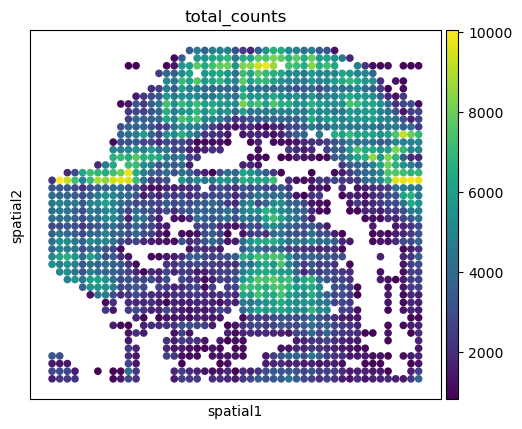

In [123]:
# sample pseudo cells from fov
dbit_seq_fov_area = dbit_seq_cutoff[(dbit_seq_cutoff.obs.x_pos > dbit_seq_left_border) &
                                    (dbit_seq_cutoff.obs.x_pos < dbit_seq_right_border) &
                                    (dbit_seq_cutoff.obs.y_pos > dbit_seq_top_border) &
                                    (dbit_seq_cutoff.obs.y_pos < dbit_seq_bottom_border)]
print(dbit_seq_fov_area)

rng = np.random.default_rng(RANDOM_SEED)
dbit_seq_fov_subset = dbit_seq_fov_area[rng.choice(dbit_seq_fov_area.n_obs, size=n_spots_dbit_seq, replace=False)].copy()
print(dbit_seq_fov_subset)

sc.pl.spatial(dbit_seq_fov_subset, color='total_counts', spot_size=1)

In [124]:
# save barcodes of spots to file
os.makedirs(os.path.dirname('dbit_seq/e11_25um_github/'), exist_ok=True)
with open('dbit_seq/e11_25um_github/fov_subset_1mm2_area_bcs.txt', 'w') as f:
    f.write('\n'.join(dbit_seq_fov_subset.obs_names))

#save reads of barcodes in file to new bam
!samtools view -b -D CB:dbit_seq/e11_25um_github/fov_subset_1mm2_area_bcs.txt {spacemake_dir_path}projects/dbit_seq/processed_data/e11_25um/illumina/complete_data/final.polyA_adapter_trimmed.bam  > dbit_seq/e11_25um_github/fov_subset_1mm2_area_reads.bam

#shuffle reads
!samtools collate -o dbit_seq/e11_25um_github/fov_subset_1mm2_area_reads_collated.bam dbit_seq/e11_25um_github/fov_subset_1mm2_area_reads.bam

In [125]:
# create subset files for fov bam
downsampling(base_path='dbit_seq/e11_25um/', max_reads=40000000, steps=10)

[E::idx_find_and_load] Could not retrieve index file for 'dbit_seq/e11_25um_github/fov_subset_1mm2_area_reads_collated.bam'
0it [00:00, ?it/s]

3995151it [00:23, 176819.88it/s]

processed 4000000 reads


7986350it [01:19, 185629.49it/s]

processed 8000000 reads


11988264it [02:42, 189706.08it/s]

processed 12000000 reads


15990178it [04:36, 188352.28it/s]

processed 16000000 reads


19984103it [06:57, 187809.04it/s]

processed 20000000 reads


23985739it [09:44, 189567.12it/s]

processed 24000000 reads


25183909it [12:50, 32687.06it/s] 


In [126]:
# run dropseqtools digitalexpression for each subset of reads
# for samples/technologies with many barcodes this is very slow so multithreading is recommended
with ThreadPoolExecutor(max_workers=10) as executor:
    subsets = os.listdir('dbit_seq/e11_25um/bam_downsampling')
    for subset in subsets:
        executor.submit(digital_expression, 'dbit_seq/e11_25um/', subset, with_intronic=True)

processing 4M subset
processing 8M subset
processing 12M subset
processing 16M subset
processing 20M subset
processing 24M subset


[Thu Mar 28 18:15:36 CET 2024] DigitalExpression --INPUT dbit_seq/e11_25um_github/bam_downsampling/fov_subset_1mm2_area_reads_collated_16M.bam --SUMMARY dbit_seq/e11_25um_github/downsampling_results/with_intronic/dropseqtools_summary_16M.txt --OUTPUT dbit_seq/e11_25um_github/downsampling_results/with_intronic/dropseqtools_dge_16M.txt.gz --CELL_BARCODE_TAG CB --MOLECULAR_BARCODE_TAG MI --CELL_BC_FILE dbit_seq/e11_25um_github/fov_subset_1mm2_area_bcs.txt --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST CODING --LOCUS_FUNCTION_LIST UTR --LOCUS_FUNCTION_LIST INTRONIC --TMP_DIR /tmp --OUTPUT_READS_INSTEAD false --OMIT_MISSING_CELLS false --EDIT_DISTANCE 1 --READ_MQ 10 --MIN_BC_READ_THRESHOLD 0 --USE_STRAND_INFO true --RARE_UMI_FILTER_THRESHOLD 0.0 --GENE_NAME_TAG gn --GENE_STRAND_TAG gs --GENE_FUNCTION_TAG gf --STRAND_STRATEGY SENSE --VERBOSITY INFO --QUIET false --VALIDATION_STRINGENCY STRICT --COMPRESSION_LEVEL 5 --MAX_RECORDS_IN_RAM 500000 --CREATE_INDEX false

In [127]:
# get total genic reads and counts for downsampling data
dbit_seq_total_counts_40M, dbit_seq_total_genic_reads_40M = get_genic_reads_and_umis('dbit_seq/e11_25um/downsampling_results/with_intronic', 40000000, 10)

In [128]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)

downsampling_reads_counts['with_intronic']['dbit_seq_40M'] = {}
downsampling_reads_counts['with_intronic']['dbit_seq_40M']['total_genic_reads'] = dbit_seq_total_genic_reads_40M
downsampling_reads_counts['with_intronic']['dbit_seq_40M']['total_counts'] = dbit_seq_total_counts_40M

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

### summary

In [6]:
# numbers obtained separately

phix = {'open_st_mb_rep1': 1 - 0.006,
        'open_st_mb_rep2': 1 - 0.008,
        'open_st_hln': 1 - 0.012,
        'open_st_mln': 1 - 0.008,
        'open_st_primary': 1 - 0.008,
        'seq_scope': 1 - 0.179,
        'stereo_seq': 1 - 0.008,
        'slide_seq': 1 - 0.008,
        'visium': 1 - 0.004,
        'dbit_seq': 1 - 0.006}

ribo = {'open_st_mb_rep1': 1 - 0.156,
        'open_st_mb_rep2': 1 - 0.199,
        'open_st_hln': 1 - 0.055,
        'open_st_mln': 1 - 0.06,
        'open_st_primary': 1 - 0.025,
        'seq_scope': 1 - 0.070,
        'stereo_seq': 1 - 0.169,
        'slide_seq': 1 - 0.072,
        'visium': 1 - 0.004,
        'dbit_seq': 1 - 0.504}

spatial_mapping = {
        'open_st_mb_rep1': 0.594,
        'open_st_mb_rep2': 0.670,
        'open_st_hln': 0.574,
        'open_st_mln': 0.616,
        'open_st_primary': 0.570,
        'seq_scope': 0.198,
        'stereo_seq': 0.705,
        'slide_seq': 0.312,
        'visium': 0.957,
        'dbit_seq': 1.0
        }

with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
downsampling_reads_counts['phix'] = phix
downsampling_reads_counts['ribo'] = ribo
downsampling_reads_counts['with_intronic']['spatial_mapping'] = spatial_mapping

with open('downsampling_reads_counts.pickle', 'wb') as f:
    pkl.dump(downsampling_reads_counts, f, protocol=pkl.HIGHEST_PROTOCOL)

In [7]:
with open('downsampling_reads_counts.pickle', 'rb') as f:
    downsampling_reads_counts = pkl.load(f)
    
open_st_mb_rep1_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['open_st_mb_rep1_40M']['total_genic_reads']
open_st_mb_rep1_total_counts_40M = downsampling_reads_counts['with_intronic']['open_st_mb_rep1_40M']['total_counts']

open_st_mb_rep2_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['open_st_mb_rep2_40M']['total_genic_reads']
open_st_mb_rep2_total_counts_40M = downsampling_reads_counts['with_intronic']['open_st_mb_rep2_40M']['total_counts']

open_st_hln_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['open_st_hln_40M']['total_genic_reads']
open_st_hln_total_counts_40M = downsampling_reads_counts['with_intronic']['open_st_hln_40M']['total_counts']

open_st_mln_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['open_st_mln_40M']['total_genic_reads']
open_st_mln_total_counts_40M = downsampling_reads_counts['with_intronic']['open_st_mln_40M']['total_counts']

open_st_primary_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['open_st_primary_40M']['total_genic_reads']
open_st_primary_total_counts_40M = downsampling_reads_counts['with_intronic']['open_st_primary_40M']['total_counts']

seq_scope_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['seq_scope_40M']['total_genic_reads']
seq_scope_total_counts_40M = downsampling_reads_counts['with_intronic']['seq_scope_40M']['total_counts']

stereo_seq_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['stereo_seq_40M']['total_genic_reads']
stereo_seq_total_counts_40M = downsampling_reads_counts['with_intronic']['stereo_seq_40M']['total_counts']

slide_seq_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['slide_seq_40M']['total_genic_reads']
slide_seq_total_counts_40M = downsampling_reads_counts['with_intronic']['slide_seq_40M']['total_counts']

visium_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['visium_40M']['total_genic_reads']
visium_total_counts_40M = downsampling_reads_counts['with_intronic']['visium_40M']['total_counts']

dbit_seq_total_genic_reads_40M = downsampling_reads_counts['with_intronic']['dbit_seq_40M']['total_genic_reads']
dbit_seq_total_counts_40M = downsampling_reads_counts['with_intronic']['dbit_seq_40M']['total_counts']

In [9]:
slide_seq_downsampling_counts = [i / 1000000 * 100 for i in slide_seq_total_counts_40M]
open_st_mb_rep1_downsampling_counts = [i / 1000000 * 100 for i in open_st_mb_rep1_total_counts_40M]
open_st_mb_rep2_downsampling_counts = [i / 1000000 * 100 for i in open_st_mb_rep2_total_counts_40M]
visium_downsampling_counts = [i / 1000000 * 100 for i in visium_total_counts_40M]
stereo_seq_downsampling_counts = [i / 1000000 * 100 for i in stereo_seq_total_counts_40M]
open_st_hln_downsampling_counts = [i / 1000000 * 100 for i in open_st_hln_total_counts_40M]
open_st_mln_downsampling_counts = [i / 1000000 * 100 for i in open_st_mln_total_counts_40M]
open_st_primary_downsampling_counts = [i / 1000000 * 100 for i in open_st_primary_total_counts_40M]
seq_scope_downsampling_counts = [i / 1000000 * 100 for i in seq_scope_total_counts_40M]
dbit_seq_downsampling_counts = [i / 1000000 * 100 for i in dbit_seq_total_counts_40M]

fig, ax = plt.subplots(dpi=800)
plt.plot([i * 4000000 /
          phix['open_st_mb_rep1'] /
          ribo['open_st_mb_rep1'] /
          spatial_mapping['open_st_mb_rep1'] 
          for i in range(1, len(open_st_mb_rep1_total_counts_40M) + 1)], 
         open_st_mb_rep1_downsampling_counts, marker='.', label='OPEN-st mouse brain rep1')
plt.plot([i * 4000000 /
          phix['open_st_mb_rep2'] /
          ribo['open_st_mb_rep2'] /
          spatial_mapping['open_st_mb_rep2'] 
          for i in range(1, len(open_st_mb_rep2_total_counts_40M) + 1)], 
         open_st_mb_rep2_downsampling_counts, marker='.', label='OPEN-st mouse brain rep2')
plt.plot([i * 4000000 / 
          phix['open_st_hln'] / 
          ribo['open_st_hln'] / 
          spatial_mapping['open_st_hln'] 
          for i in range(1, len(open_st_hln_total_counts_40M) + 1)], 
         open_st_hln_downsampling_counts, marker='.', label='OPEN-st human lymph node')
plt.plot([i * 4000000 / 
          phix['open_st_mln'] /
          ribo['open_st_mln'] / 
          spatial_mapping['open_st_mln'] 
          for i in range(1, len(open_st_mln_total_counts_40M) + 1)], 
         open_st_mln_downsampling_counts, marker='.', label='OPEN-st human lymph node metastatic')
plt.plot([i * 4000000 / 
          phix['open_st_primary'] / 
          ribo['open_st_primary'] /
          spatial_mapping['open_st_primary'] 
          for i in range(1, len(open_st_primary_total_counts_40M) + 1)],
         open_st_primary_downsampling_counts, marker='.', label='OPEN-st primary tumor')
plt.plot([i * 4000000 / 
          phix['seq_scope'] / 
          ribo['seq_scope'] / 
          spatial_mapping['seq_scope'] 
          for i in range(1, len(seq_scope_total_counts_40M) + 1)], 
         seq_scope_downsampling_counts, marker='.', label='seq-scope mouse liver')
plt.plot([i * 4000000 / 
          phix['stereo_seq'] /
          ribo['stereo_seq'] / 
          spatial_mapping['stereo_seq'] 
          for i in range(1, len(stereo_seq_total_counts_40M) + 1)], 
         stereo_seq_downsampling_counts, marker='.', label='stereo-seq mouse brain')
plt.plot([i * 4000000 / 
          phix['slide_seq'] / 
          ribo['slide_seq'] / 
          spatial_mapping['slide_seq'] 
          for i in range(1, len(slide_seq_total_counts_40M) + 1)],
         slide_seq_downsampling_counts, marker='.', label='slide-seq v2 mouse e9_5 brain')
plt.plot([i * 4000000 / 
          phix['visium'] / 
          ribo['visium'] / 
          spatial_mapping['visium'] 
          for i in range(1, len(visium_total_counts_40M) + 1)], 
         visium_downsampling_counts, marker='.', label='visium mouse brain')
plt.plot([i * 4000000 / 
          phix['dbit_seq'] / 
          ribo['dbit_seq'] / 
          spatial_mapping['dbit_seq'] 
          for i in range(1, len(dbit_seq_total_counts_40M) + 1)], 
         dbit_seq_downsampling_counts, marker='.', label='dbit-seq mouse e11 tail')

ax.set_xticklabels([str(i * 20 - 20) for i in range(10)])
plt.xlabel('Total reads per mm^2 (million)')
plt.ylabel(f'UMIs/cell (100 um^2)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

/tmp/ipykernel_2630932/2824480810.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i * 20 - 20) for i in range(10)])
